In [2]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import os
from osgeo import ogr
import gdal
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  

# hand made functions
from Rouss1 import Imreduction, gp2idomain, gp2cellids,cellidBD, get_heads, get_spdis, get_MNTbbox

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [3]:
model_dir = "workingDis"
model_name="dis_test"
exe_name="../../exe/mf6"
R_path="../data/limiteModeleRoussillon_poly.shp" # path to the shp of the aquifer
Agly_path="../data/Fleuves/Agly_ludo.shp" # path to Agly
MNT_path= "../../../../../MNT_demo_5m.tif"

# get x0,y0,y1 and x1
x0,y0,x1,y1 = get_MNTbbox(MNT_path)

In [291]:
#spatial parameters
Lx = x1-x0
Ly = y1-y0
nlay = 1
ncol = 100
nrow = 100
delr = np.ones(ncol)*(Lx/ncol)
delc = np.ones(nrow)*(Ly/nrow)
botm = -100
top = 10.
idomain = np.zeros((nrow*ncol))

In [292]:
R = gp.read_file(R_path) # import shapefile with geopandas
grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0)

#cells inside the aquifer become active and return the lst of the cellids
lst_domain = gp2idomain(R,grid,idomain,area=3)

In [6]:
#BC Agly
BC_Agly = gp.read_file(Agly_path)
#BC_Agly = BC_Agly.sort_values(by="ORDRE").set_index("ORDRE") # sort multilines by the ORDRE column, not necessary with the new file that I created

In [367]:
ix = GridIntersect(grid) # structured doesn't work everytime... 
                                             # but it allows to keep the order of the cells !
lst_Agy = [];lst_Agy_long=[];o = -1

for i in range(BC_Agly.shape[0]):
    cellids = ix.intersect_linestring(BC_Agly.iloc[i].geometry).cellids
    long = ix.intersect_linestring(BC_Agly.iloc[i].geometry).lengths
    for irow,icol in cellids:
        o = o + 1
        cell_riv = (0,irow,icol)
        if (cell_riv not in lst_Agy) & (cell_riv in lst_domain):
            lst_Agy.append(cell_riv)
            lst_Agy_long.append(long[o])

# calculate the heads along the river
lst_Agy_long = np.array(lst_Agy_long) # make an array
H_us = 30 # head up stream
H_ds = 0 # head down stream
dh_dl = (H_ds-H_us)/lst_Agy_long.sum() #slope of the head along the river (linear interpolation)

H_riv = np.zeros(lst_Agy_long.shape[0], dtype=np.float) # initiate an array for the head in the river

for idx in range(lst_Agy_long.shape[0]): # loop for calculating the heads (can also be used for interpolate the botm of the river)
    if idx == 0:
        len_cum = 0.5 * lst_Agy_long[0]
    else:
        len_cum += 0.5 * (lst_Agy_long[idx-1]+lst_Agy_long[idx])
    H_riv[idx] = H_us + len_cum * dh_dl
lst_Agy

[(0, 32, 58),
 (0, 32, 59),
 (0, 33, 59),
 (0, 33, 60),
 (0, 33, 94),
 (0, 33, 95),
 (0, 34, 60),
 (0, 34, 61),
 (0, 34, 62),
 (0, 34, 63),
 (0, 34, 64),
 (0, 34, 65),
 (0, 34, 66),
 (0, 34, 67),
 (0, 34, 68),
 (0, 34, 69),
 (0, 34, 70),
 (0, 34, 71),
 (0, 34, 93),
 (0, 34, 94),
 (0, 35, 71),
 (0, 35, 72),
 (0, 35, 88),
 (0, 35, 89),
 (0, 35, 90),
 (0, 35, 91),
 (0, 35, 92),
 (0, 35, 93),
 (0, 36, 72),
 (0, 36, 73),
 (0, 36, 85),
 (0, 36, 86),
 (0, 36, 87),
 (0, 36, 88),
 (0, 37, 73),
 (0, 37, 74),
 (0, 37, 75),
 (0, 37, 76),
 (0, 37, 77),
 (0, 37, 83),
 (0, 37, 84),
 (0, 37, 85),
 (0, 38, 77),
 (0, 38, 78),
 (0, 38, 79),
 (0, 38, 80),
 (0, 38, 81),
 (0, 38, 82),
 (0, 38, 83)]

In [370]:
## this block extracts coordinates of the points in the shapefile and extract cellids one by one of each segement
# IN THE RIGHT ORDER

coord_agly=[]
for x,y in zip(BC_Agly.geometry[0].xy[0],BC_Agly.geometry[0].xy[1]):
    coord_agly.append((x,y))

cellids_agy=[];verti=[];long_agy=[]

for i in range(len(coord_agly)):
    if i < len(coord_agly)-1:
        lsi = LineString([coord_agly[i],coord_agly[i+1]])                  
        cellids = ix.intersect_linestring(lsi).cellids
        
        if len(cellids)>1:
            
            dirx = coord_agly[i+1][0]-coord_agly[i][0]
            diry = coord_agly[i+1][1]-coord_agly[i][1]
            
            for x,y in ix.intersect_linestring(lsi).vertices:
                verti.append(x)
            vertix = np.array(verti)[:,0]
            vertiy = np.array(verti)[:,1]
            df = pd.DataFrame({"cellids":cellids,"vertix":vertix,"vertiy":vertiy,"dirx":dirx,"diry":diry})
            
            if diry > 0 and dirx > 0:
                df.sort_values(by=["vertix","vertiy"],ascending=[True,True],inplace=True)
                
            if diry < 0 and dirx < 0:
                df.sort_values(by=["vertix","vertiy"],ascending=[False,False],inplace=True)
                
            if diry > 0 and dirx < 0:
                df.sort_values(by=["vertix","vertiy"],ascending=[True,False],inplace=True)    
            
            for irow,icol in df.cellids:
                cell_riv = (0,irow,icol)
            
                if (cell_riv not in cellids_agy) & (cell_riv in lst_domain):
                    cellids_agy.append(cell_riv)
                    
            verti=[]
            
        else :    
            for irow,icol in cellids:
                cell_riv = (0,irow,icol)

                if (cell_riv not in cellids_agy) & (cell_riv in lst_domain):
                    cellids_agy.append(cell_riv)

In [240]:
i = 5
lsi = LineString([(680000,6186998),(681000,6187900)])  

In [242]:
ix.intersect_linestring(lsi).vertices

array([((680445.6762749446, 6187400.0), (680700.0, 6187629.4)),
       ((680700.0, 6187629.4), (681000.0, 6187900.0)),
       ((680000.0, 6186998.0), (680445.6762749446, 6187400.0))],
      dtype=object)

In [351]:
sim = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name=exe_name, 
                             sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

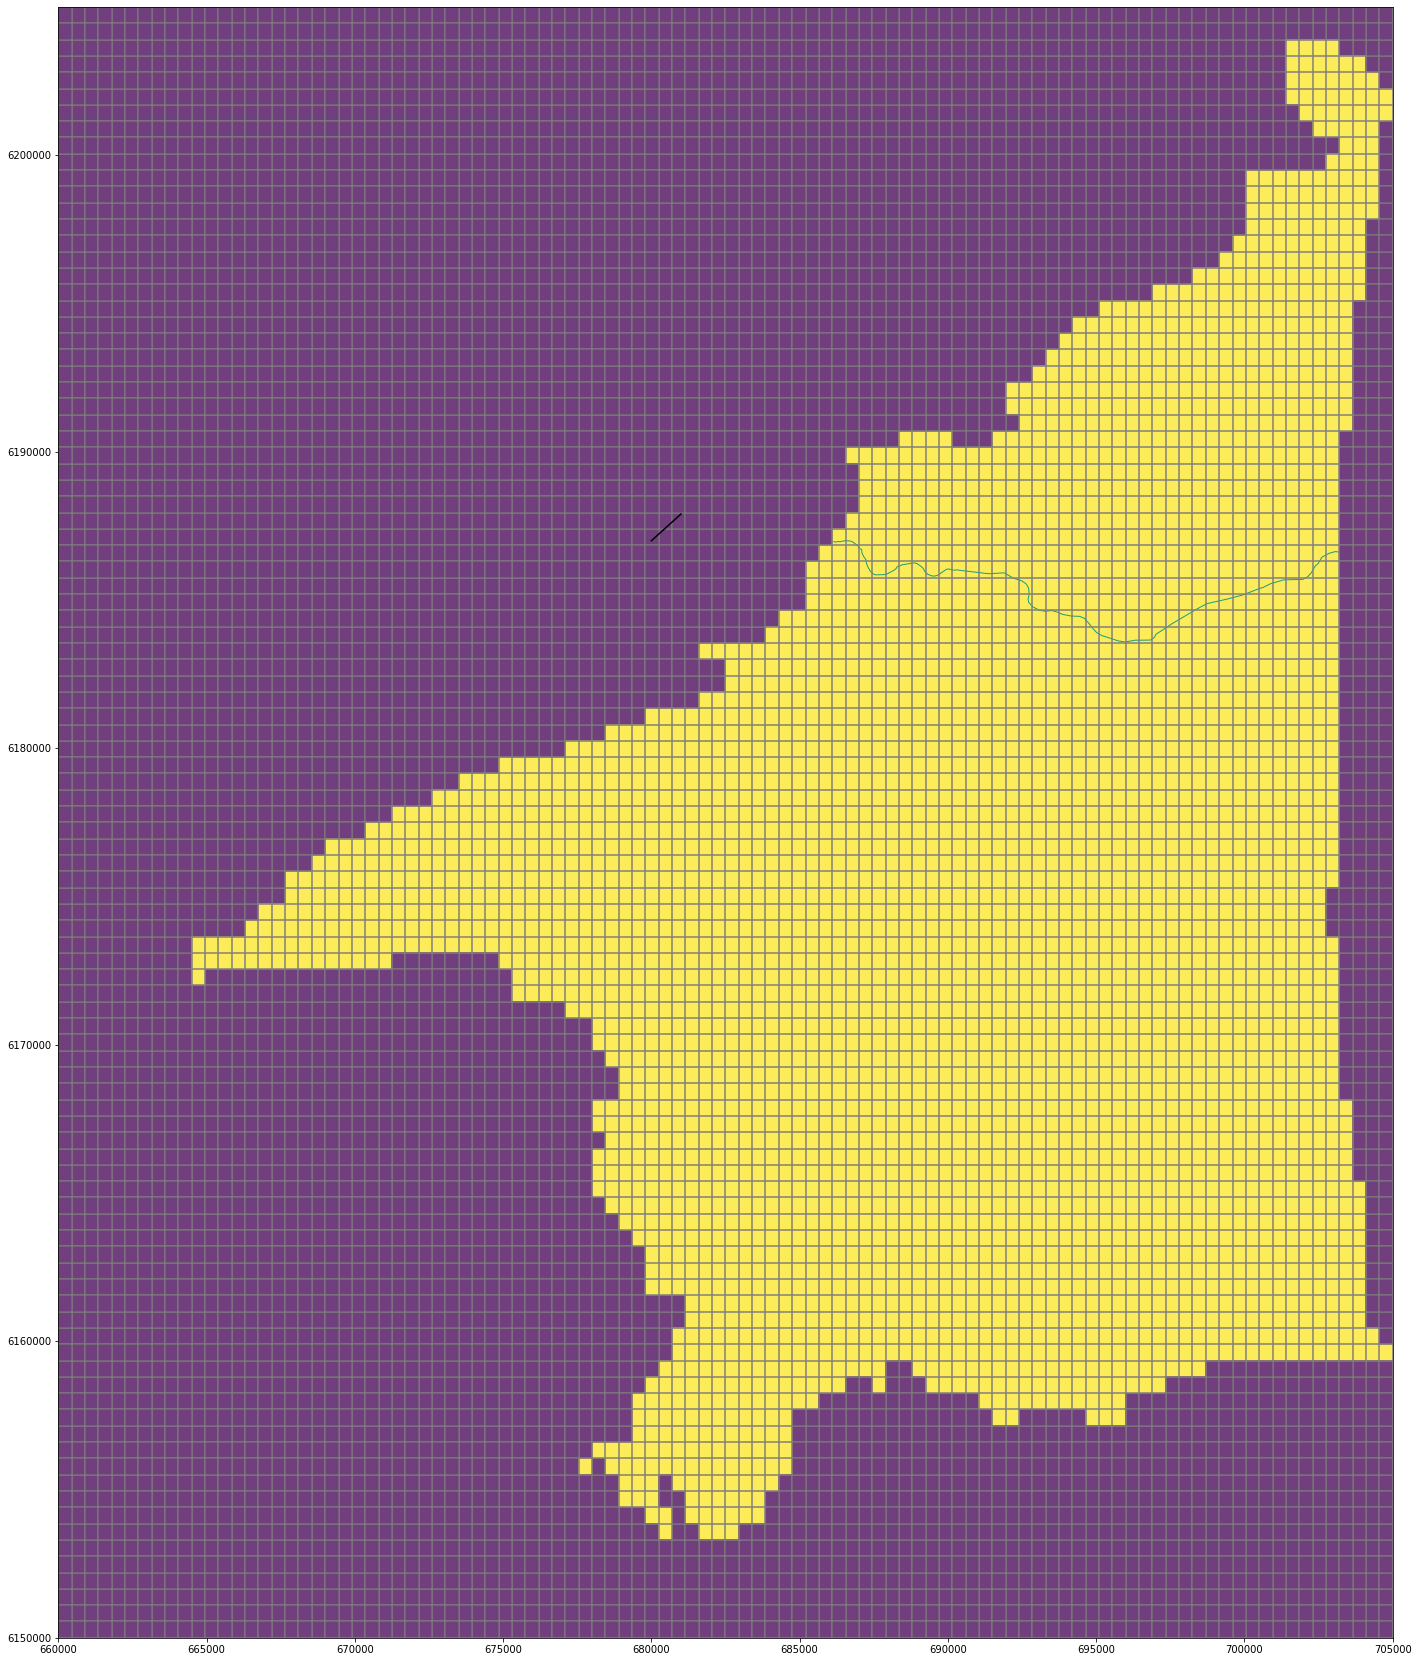

In [352]:
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(aspect='equal')

mm = fp.plot.PlotMapView(model=gwf)
mm.plot_array(dis.idomain.array,alpha=0.5)
#fp.plot.plot_shapefile(R_path,ax=ax,facecolor = "brown",alpha=0.5)
fp.plot.plot_shapefile(Agly_path,ax=ax,facecolor="none",linewidth = 1)
mm.plot_grid()

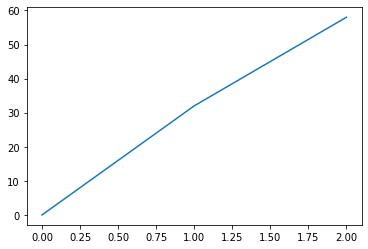

In [354]:
plt.plot(cellids_agy[0])

In [366]:
cellids_agy

[(0, 32, 58),
 (0, 32, 59),
 (0, 33, 59),
 (0, 33, 60),
 (0, 34, 60),
 (0, 34, 61),
 (0, 34, 62),
 (0, 34, 63),
 (0, 34, 64),
 (0, 34, 65),
 (0, 34, 66),
 (0, 34, 67),
 (0, 34, 68),
 (0, 34, 69),
 (0, 34, 70),
 (0, 34, 71),
 (0, 35, 71),
 (0, 35, 72),
 (0, 36, 72),
 (0, 36, 73),
 (0, 37, 73),
 (0, 37, 74),
 (0, 37, 75),
 (0, 37, 76),
 (0, 37, 77),
 (0, 38, 77),
 (0, 38, 78),
 (0, 38, 79),
 (0, 38, 80),
 (0, 38, 81),
 (0, 38, 82),
 (0, 38, 83),
 (0, 37, 83),
 (0, 37, 84),
 (0, 37, 85),
 (0, 36, 85),
 (0, 36, 86),
 (0, 36, 87),
 (0, 36, 88),
 (0, 35, 88),
 (0, 35, 89),
 (0, 35, 90),
 (0, 35, 91),
 (0, 35, 92),
 (0, 35, 93),
 (0, 34, 93),
 (0, 34, 94),
 (0, 33, 94),
 (0, 33, 95)]